## Original Source: https://www.datacamp.com/tutorial/sam2-fine-tuning

In [9]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import random


In [10]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed(42)

In [11]:
torch.cuda.is_available()

True

In [12]:
# # Path to the water segmentation dataset folder
# data_dir = r"C:\Users\dockn\SAM-code\EGU2024_total_river\train"
# images_dir = os.path.join(data_dir, r"JPEGImages\dataset")
# masks_dir = os.path.join(data_dir, r"Annotations\dataset")

# train_data = []
# for img, msk in zip(os.listdir(images_dir), os.listdir(masks_dir)):
#    train_data.append({
#        "image": os.path.join(images_dir, img),
#        "annotation": os.path.join(masks_dir, msk)
#    })

# val_imgs = r"C:\Users\dockn\SAM-code\EGU2024_total_river\val\JPEGImages\dataset"
# val_msks = r"C:\Users\dockn\SAM-code\EGU2024_total_river\val\Annotations\dataset"
# val_data = []
# for img, msk in zip(os.listdir(val_imgs), os.listdir(val_msks)):
#    val_data.append({
#       "image": os.path.join(val_imgs, img),
#       "annotation": os.path.join(val_msks, msk)
#    })

# # Prepare the testing data list (if needed for inference or evaluation later)
# test_dir = r"C:\Users\dockn\SAM-code\EGU2024_total_river\test"
# t_img = os.path.join(test_dir, "JPEGImages", "dataset")
# t_msk = os.path.join(test_dir, "Annotations", "dataset")

# test_data = []
# for img, msk in zip(os.listdir(t_img), os.listdir(t_msk)):
#    # Append image and corresponding mask paths
#    test_data.append({
#        "image": os.path.join(t_img, img),
#        "annotation": os.path.join(t_msk, msk)
#   })


In [13]:
# Path to the water segmentation dataset folder
data_dir = r"D:\riwa_v2"
images_dir = os.path.join(data_dir, r"images")
masks_dir = os.path.join(data_dir, r"masks")

train_data = []
for img, msk in zip(os.listdir(images_dir), os.listdir(masks_dir)):
   train_data.append({
       "image": os.path.join(images_dir, img),
       "annotation": os.path.join(masks_dir, msk)
   })

val_imgs = r"D:\riwa_v2\validation\images"
val_msks = r"D:\riwa_v2\validation\masks"
val_data = []
for img, msk in zip(os.listdir(val_imgs), os.listdir(val_msks)):
   val_data.append({
      "image": os.path.join(val_imgs, img),
      "annotation": os.path.join(val_msks, msk)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_dir = r"D:\riwa_v2\test"
t_img = os.path.join(test_dir, "images")
t_msk = os.path.join(test_dir, "masks")

test_data = []
for img, msk in zip(os.listdir(t_img), os.listdir(t_msk)):
   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(t_img, img),
       "annotation": os.path.join(t_msk, msk)
   })


In [14]:
def read_batch(data, index, visualize_data=False):
    # Select a random entry
    ent = data[index % len(data)]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    # Change multi masks into a single binary mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)
        binary_mask = np.maximum(binary_mask, mask)

    if visualize_data:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 2, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, len(inds)


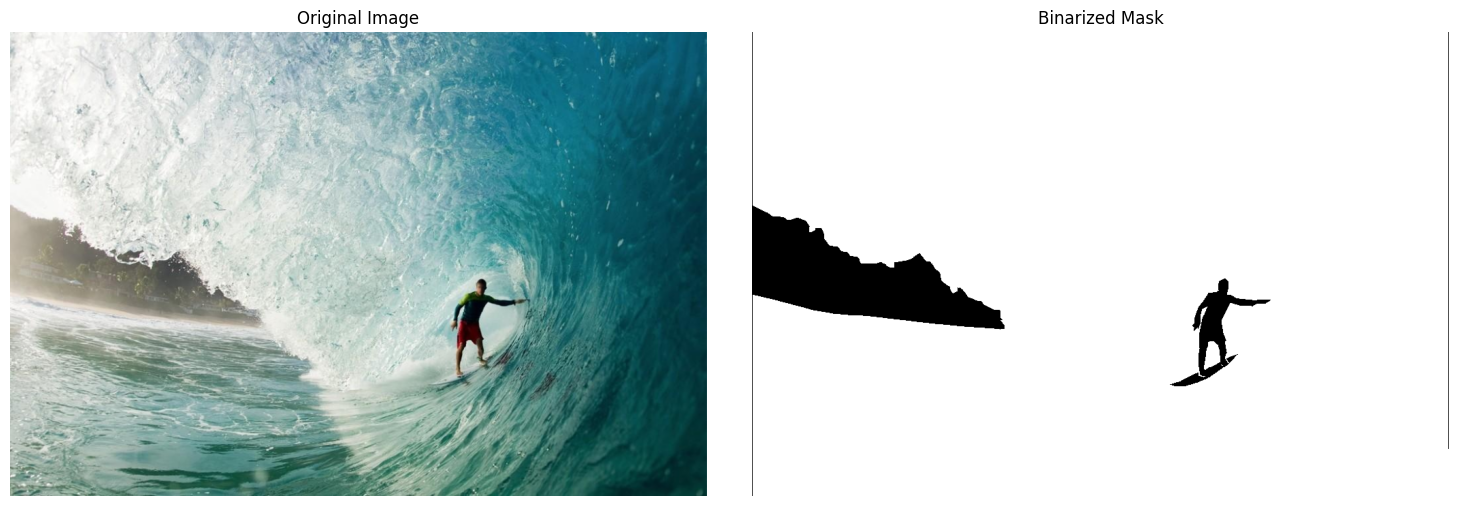

In [15]:
# Visualize the data
Img1, masks1, num_masks = read_batch(train_data, 5, visualize_data=True)

In [19]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import wandb

EPOCH = 20

NO_OF_STEPS = len(train_data)

def train_model(config):
    sam2_checkpoint, model_cfg = config["checkpoint_cfg"]

    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
    predictor = SAM2ImagePredictor(sam2_model)

    FINE_TUNED_MODEL_NAME = f'{" ".join(
        [
            " ".join((i[0], str(i[1][1])))
            if isinstance(i[1], tuple)
            else " ".join((i[0], str(i[1])))
            for i in config.items()
        ]
    )}'

    # if os.path.isdir(FINE_TUNED_MODEL_NAME): return 0
    
    os.makedirs(FINE_TUNED_MODEL_NAME, exist_ok=True)
    
    wandb.init(
        project="sam2",
        config=config
    )

    wandb.run.name = FINE_TUNED_MODEL_NAME

    optimizer = torch.optim.AdamW(
        params=predictor.model.parameters(),
        lr=config["optimizer"][1],
        weight_decay=config["optimizer"][0]
    )

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=config["step_size"], 
        gamma=config["gamma"]
    )
    
    scaler = torch.cuda.amp.GradScaler()
    accumulation_steps = config["accumulation_steps"]
    focus = config["focus"]
    # global_step = 0
    # valid_step = 0

    for epoch in range(EPOCH):
        predictor.model.sam_mask_decoder.train()
        predictor.model.sam_prompt_encoder.train()
        
        for step in range(1, NO_OF_STEPS + 1):
            with torch.cuda.amp.autocast():
                image, mask, num_masks = read_batch(train_data, step, visualize_data=False)
                predictor.set_image(image)

                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=None,
                    boxes=None,
                    masks=None,
                )

                high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

                low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=True,
                    repeat_image=False,
                    high_res_features=high_res_features,
                )

                prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

                gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
                prd_mask = torch.sigmoid(prd_masks[:, 0])
                # -y * (1-y_hat) ** gamma * log(y_hat) +
                # -(1-y) * (y_hat) ** gamma * log(1-y_hat)
                seg_loss = (
                    0.75 * (-gt_mask * (1-prd_mask) ** focus * torch.log(prd_mask + 1e-6)) - 
                    0.25 * (1 - gt_mask) ** focus * torch.log((1 - prd_mask) + 1e-5)
                ).mean() # focal, gamma == 0

                inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
                iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
                score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
                loss = seg_loss + score_loss * 0.05

                loss = loss / accumulation_steps
                scaler.scale(loss).backward()

                # wandb.log(
                #     {
                #         "loss": loss,
                #         "IoU": iou,
                #         "train_step": step + NO_OF_STEPS * epoch
                #     },
                #     step=global_step
                # )

                torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

                if step % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    predictor.model.zero_grad()


                if step == 1:
                    mean_iou = 0

                mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
                # global_step += 1

        scheduler.step()

        # validation
        predictor.model.sam_prompt_encoder.eval()
        predictor.model.sam_mask_decoder.eval()
        
        with torch.no_grad():
            for i in range(len(val_data)):
                if i == 0:
                    mean_val_iou = 0

                val_image, val_mask, _ = read_batch(val_data, i)
                predictor.set_image(val_image)

                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=None,
                    boxes=None,
                    masks=None,
                )

                high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

                low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=True,
                    repeat_image=False,
                    high_res_features=high_res_features,
                )

                prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

                gt_mask = torch.tensor(val_mask.astype(np.float32)).cuda()
                prd_mask = torch.sigmoid(prd_masks[:, 0])

                inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
                iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

                mean_val_iou = mean_val_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

                # wandb.log(
                #     {
                #     "val_iou": iou,
                #     "valid_step": valid_step,
                #     },
                #     step = global_step
                # )

                # valid_step += 1
                # global_step += 1
                
        wandb.log(
            {
            "mean_val_iou": mean_val_iou,
            "mean_iou": mean_iou,
            "epoch": epoch
            }
        )
                
        model_path = os.path.join(FINE_TUNED_MODEL_NAME, f"{FINE_TUNED_MODEL_NAME}_{epoch}.torch")
        torch.save(predictor.model.state_dict(), model_path)

    wandb.finish()

    return mean_val_iou

search_space = {
    "checkpoint_cfg": hp.choice("checkpoint_cfg", [
        ("../checkpoints/sam2_hiera_tiny.pt", "sam2_hiera_t.yaml"),
        ("../checkpoints/sam2_hiera_small.pt", "sam2_hiera_s.yaml"),
        ("../checkpoints/sam2_hiera_base_plus.pt", "sam2_hiera_b+.yaml"),
        # ("../checkpoints/sam2_hiera_large.pt", "sam2_hiera_l.yaml")
    ]),
    "optimizer": hp.choice("optimizer", [(1e-4, 0.0001), (4e-5, 1e-5)]),
    "step_size": 8,
    "gamma": 0.2,
    "accumulation_steps": 4,
    "focus": 2
}

def objective(params):
    mean_val_iou = train_model(params)
    loss = -mean_val_iou
    return {"loss": loss, "status": STATUS_OK}
    
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.

wandb: Currently logged in as: a01026108469 (recsys08). Use `wandb login --relogin` to force relogin



D:\SAM-code\segment-anything-2\sam2\modeling\backbones\hieradet.py:68: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(



epoch,19
mean_iou,0.83945
mean_val_iou,0.66131


  5%|▌         | 1/20 [7:50:38<149:02:15, 28238.69s/trial, best loss: -0.6613079504659559]

epoch,19
mean_iou,0.84039
mean_val_iou,0.66377


 10%|█         | 2/20 [15:39:44<140:55:16, 28184.28s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.82716
mean_val_iou,0.63493


 15%|█▌        | 3/20 [22:09:58<122:48:20, 26005.93s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.8674
mean_val_iou,0.65628


 20%|██        | 4/20 [28:39:34<110:58:02, 24967.67s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.82716
mean_val_iou,0.63458


 25%|██▌       | 5/20 [35:09:14<101:38:45, 24395.05s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.84104
mean_val_iou,0.66361


 30%|███       | 6/20 [42:58:29<99:50:29, 25673.52s/trial, best loss: -0.6637714395703517] 

epoch,19
mean_iou,0.86403
mean_val_iou,0.65797


 35%|███▌      | 7/20 [49:29:16<90:04:52, 24945.60s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.8272
mean_val_iou,0.63415


 40%|████      | 8/20 [56:01:07<81:37:45, 24488.81s/trial, best loss: -0.6637714395703517]

epoch,19
mean_iou,0.89032
mean_val_iou,0.68242


 45%|████▌     | 9/20 [68:49:36<95:28:42, 31247.54s/trial, best loss: -0.6824164983076898]

epoch,19
mean_iou,0.86037
mean_val_iou,0.6579


 50%|█████     | 10/20 [74:41:44<78:07:15, 28123.52s/trial, best loss: -0.6824164983076898]

epoch,19
mean_iou,0.89234
mean_val_iou,0.6821


 55%|█████▌    | 11/20 [88:27:57<86:43:14, 34688.30s/trial, best loss: -0.6824164983076898]

epoch,19
mean_iou,0.88862
mean_val_iou,0.67783


 60%|██████    | 12/20 [95:51:24<71:37:18, 32229.77s/trial, best loss: -0.6824164983076898]

epoch,19
mean_iou,0.86427
mean_val_iou,0.66852


 65%|██████▌   | 13/20 [102:03:06<56:49:16, 29222.37s/trial, best loss: -0.6824164983076898]

epoch,19
mean_iou,0.84994
mean_val_iou,0.64168


 70%|███████   | 14/20 [114:50:23<57:10:06, 34301.13s/trial, best loss: -0.6824164983076898]

 70%|███████   | 14/20 [117:17:36<50:16:07, 30161.18s/trial, best loss: -0.6824164983076898]


KeyboardInterrupt: 

In [20]:
def read_image(image_path, mask_path):
   img = cv2.imread(image_path)[..., ::-1]
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

In [21]:
def calculate_iou(segmentation_mask1, segmentation_mask2):
    if segmentation_mask1.shape != segmentation_mask2.shape:
        raise ValueError("두 세그멘테이션 마스크는 동일한 크기여야 합니다.")

    intersection = np.logical_and(segmentation_mask1, segmentation_mask2)
    intersection_area = np.sum(intersection)

    union = np.logical_or(segmentation_mask1, segmentation_mask2)
    union_area = np.sum(union)

    iou = intersection_area / union_area if union_area != 0 else 0.0

    return iou

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

실험 결과 Img 번호: 2, 25, 29

In [17]:
from PIL import Image

In [18]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_l.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

In [26]:
FINE_TUNED_MODEL_WEIGHTS = r"C:\Users\dockn\SAM-code\segment-anything-2\notebooks\accumulation_steps 4 checkpoint_cfg sam2_hiera_l.yaml gamma 0.2 optimizer 1e-05 step_size 8\accumulation_steps 4 checkpoint_cfg sam2_hiera_l.yaml gamma 0.2 optimizer 1e-05 step_size 8_9.torch"


sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

predictor.model.eval()

results = []
with torch.no_grad():
    for idx, selected_entry in enumerate(test_data):
        image_path = selected_entry['image']
        mask_path = selected_entry['annotation']

        image, mask, num_masks = read_batch(test_data, idx, visualize_data=False)
        predictor.set_image(image)

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=False,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

        results.append(iou)

print(f"Test mIoU:{sum(results) / len(results)}")

Test mIoU:tensor([0.7970], device='cuda:0')


In [27]:
results

[tensor([0.8272], device='cuda:0'),
 tensor([0.9576], device='cuda:0'),
 tensor([0.9910], device='cuda:0'),
 tensor([0.9711], device='cuda:0'),
 tensor([0.7835], device='cuda:0'),
 tensor([0.9843], device='cuda:0'),
 tensor([0.9638], device='cuda:0'),
 tensor([0.], device='cuda:0'),
 tensor([0.9544], device='cuda:0'),
 tensor([0.], device='cuda:0'),
 tensor([0.7330], device='cuda:0'),
 tensor([0.9635], device='cuda:0'),
 tensor([0.9631], device='cuda:0'),
 tensor([0.3820], device='cuda:0'),
 tensor([0.7686], device='cuda:0'),
 tensor([0.9329], device='cuda:0'),
 tensor([0.], device='cuda:0'),
 tensor([0.9646], device='cuda:0'),
 tensor([0.8618], device='cuda:0'),
 tensor([0.8414], device='cuda:0'),
 tensor([0.4590], device='cuda:0'),
 tensor([0.8757], device='cuda:0'),
 tensor([0.9517], device='cuda:0'),
 tensor([0.8850], device='cuda:0'),
 tensor([0.8798], device='cuda:0'),
 tensor([0.8090], device='cuda:0'),
 tensor([0.9582], device='cuda:0'),
 tensor([0.9873], device='cuda:0'),
 ten

0.9454607915815358


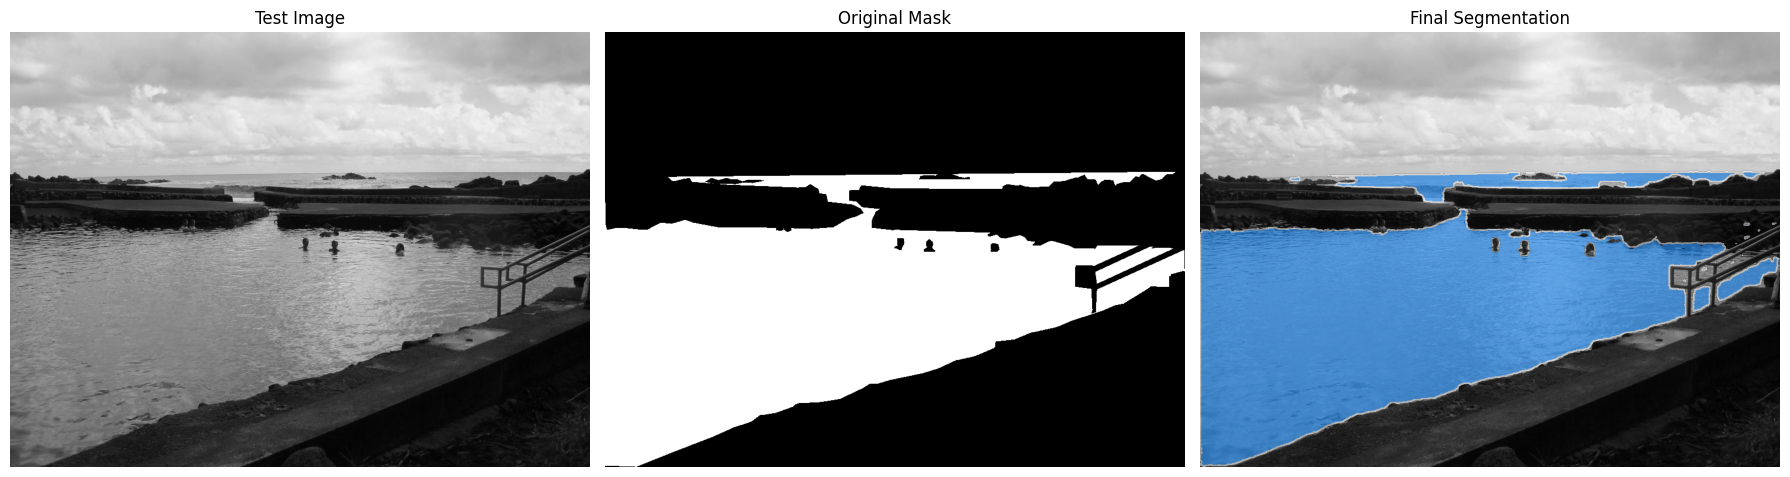

In [ ]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)

# # selected_entry = test_data[29]
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, gt = read_image(image_path, mask_path)

# # Build net and load weights
# predictor = SAM2ImagePredictor(sam2_model)
# predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=None,
       point_labels=None
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks)
np_scores = scores
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# # Combine masks to create the final segmentation map
# for i in range(sorted_masks.shape[0]):
#     mask = sorted_masks[i]

#     mask_bool = mask.astype(bool)
#     mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
#     seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
#     occupancy_mask[mask_bool] = True  # Update occupancy_mask

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask', fontdict={"size": 32})
plt.imshow(gt, cmap='gray')
plt.axis('off')

seg_map = sorted_masks[0]
iou = calculate_iou(gt, seg_map)
print(iou)

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(image)
show_mask(seg_map, plt.gca())
plt.axis('off')

plt.tight_layout()
plt.show()